In [1]:
%set_env CUDA_VISIBLE_DEVICES=0
from transformer_heads import create_headed_qlora, load_lora_with_heads
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    LlamaTokenizer,
    LlamaForCausalLM,
    Trainer,
    BitsAndBytesConfig,
    TrainingArguments,
    GenerationConfig,
)
from transformer_heads.util.helpers import DataCollatorWithPadding, get_model_params
from peft import LoraConfig
from transformer_heads.config import HeadConfig
from transformer_heads.util.model import print_trainable_parameters
from transformer_heads.util.evaluate import (
    evaluate_head_wise,
)
from transformer_heads import load_headed
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import audioop

env: CUDA_VISIBLE_DEVICES=0


ModuleNotFoundError: No module named 'transformer_heads'

In [2]:
# Parameters
model_path = "meta-llama/Llama-2-7b-hf"
train_batch_size = 2
eval_batch_size = 2
train_epochs = 1
eval_epochs = 1
logging_steps = 100

In [3]:
model_params = get_model_params(model_path)
model_class = model_params["model_class"]
hidden_size = model_params["hidden_size"]
vocab_size = model_params["vocab_size"]
print(model_params)

{'vocab_size': 32000, 'max_position_embeddings': 2048, 'hidden_size': 4096, 'intermediate_size': 11008, 'num_hidden_layers': 32, 'num_attention_heads': 32, 'num_key_value_heads': 32, 'hidden_act': 'silu', 'initializer_range': 0.02, 'rms_norm_eps': 1e-05, 'pretraining_tp': 1, 'use_cache': True, 'rope_theta': 10000.0, 'rope_scaling': None, 'attention_bias': False, 'attention_dropout': 0.0, 'mlp_bias': False, 'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': 'bfloat16', 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': False, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 

In [8]:
# Head config
# Config isn't anything but a guess 
head_configs = [
    HeadConfig(
        name=f"reduced_output",
        layer_hook=-1,
        in_size=hidden_size,
        output_activation="linear",
        pred_for_sequence=True,
        loss_fct="cross_entropy",
        num_outputs=128,
    )
]

In [5]:
# This is a dummy data-set
#dd = load_dataset('imdb')

In [11]:
from numpy.lib.stride_tricks import sliding_window_view
raw_data = np.fromfile(f'data/raw_data/w0.data', dtype = np.int16)
for i in range(1, 100):
        raw_data = np.append(raw_data, np.fromfile('data/raw_data/w{}.data'.format(i), np.int16))

data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) 
signal_real = signal_real.tobytes()
biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
ndata = np.frombuffer(data, dtype = np.uint8)
data = np.right_shift(ndata, 1)
data_split = sliding_window_view(data, 257)
d = data_split[np.random.choice(data_split.shape[0], 200000, replace=False), :]

In [12]:
def one_hot_encode(ascii_value):
    """Create a one-hot encoded vector for the given ASCII value."""
    one_hot = np.ones(128)*-10 # ASCII values from 0 to 127
    one_hot[ascii_value] = 1
    return one_hot

inputs = d[:, :256] 
targets = d[:, 256:]

targets = targets.flatten()  # Now targets has shape (x,)

# One-hot encode the targets
one_hot_targets = np.array([val for val in targets])
ascii_inputs = np.array([[''.join(map(chr, row)) for row in inputs]])

# Create a Hugging Face dataset
data = {
    'input': list(ascii_inputs.flatten()),  # Convert to list of lists for compatibility
    'reduced_output': targets #one_hot_targets
}
hf_dataset = Dataset.from_dict(data)
train = hf_dataset

In [13]:
from numpy.lib.stride_tricks import sliding_window_view
raw_data = np.fromfile(f'data/test/w_test.data', dtype = np.int16)

data_iq = raw_data[0::2] + 1j*raw_data[1::2]
signal_real = np.real(data_iq).copy().astype(np.int16) 
signal_real = signal_real.tobytes()
biased = audioop.lin2lin(signal_real, 2, 1)
data = audioop.bias(biased, 1, 2**7)
ndata = np.frombuffer(data, dtype = np.uint8)
data = np.right_shift(ndata, 1)
data_split = sliding_window_view(data, 257)
d = data_split[np.random.choice(data_split.shape[0], 10000, replace=False), :]

In [14]:
def one_hot_encode(ascii_value):
    """Create a one-hot encoded vector for the given ASCII value."""
    one_hot = np.ones(128) * -10  # ASCII values from 0 to 127
    one_hot[ascii_value] = 0
    return one_hot

inputs = d[:, :256] 
targets = d[:, 256:]

targets = targets.flatten()  # Now targets has shape (x,)

# One-hot encode the targets
one_hot_targets = np.array(val for val in targets)
ascii_inputs = np.array([[''.join(map(chr, row)) for row in inputs]])

# Create a Hugging Face dataset
data = {
    'input': list(ascii_inputs.flatten()),  # Convert to list of lists for compatibility
    'reduced_output': targets #one_hot_targets
}
hf_dataset = Dataset.from_dict(data)
test = hf_dataset

In [15]:
dd = DatasetDict({
    'train': train,
    'test': test,
})


In [16]:
tokenizer = LlamaTokenizer.from_pretrained(model_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token


def processing_function(examples):
    out = tokenizer(examples['input'], padding=False, truncation=True)
    return out

for split in dd.keys():
    dd[split] = dd[split].shuffle()
    dd[split] = dd[split].map(processing_function, batched=True)

dd.set_format(
    type="torch",
    #device = 'cuda',
    columns=["input_ids", "attention_mask"] + [x.name for x in head_configs],
)
for split in dd.keys():
    dd[split] = dd[split].remove_columns(["input"])

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [17]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=False,
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.float32,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)
#lora_config = LoraConfig(
#    r=32,
#    lora_alpha=16,
#    target_modules=None,
#    lora_dropout=0.0,
#    bias="none",
#    task_type="CAUSAL_LM",
#)
model = load_headed(
    base_model_class=model_class,
    model_name=model_path,
    quantization_config=quantization_config,
    head_configs=head_configs,
    device_map='auto'#{"": torch.cuda.current_device()},
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of TransformerWithHeads were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['heads.reduced_output.lins.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print_trainable_parameters(model)

all params: 6607867904 || trainable params: 524288 || trainable%: 0.00793429904497074
params by dtype: defaultdict(<class 'int'>, {torch.float32: 131862528, torch.int8: 6476005376})
trainable params by dtype: defaultdict(<class 'int'>, {torch.float32: 524288})


In [18]:
collator = DataCollatorWithPadding(
    feature_name_to_padding_value={
        "input_ids": tokenizer.pad_token_id,
        "attention_mask": 0,
    }
)

In [19]:
train_batch_size = 2
eval_batch_size = 2
train_epochs = 1
eval_epochs = 1
logging_steps = 100

#new_evals = evaluate_head_wise(
#    model, dd["test"].select(range(10)), collator, epochs=eval_epochs, batch_size=eval_batch_size
#)

In [16]:
import gc
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [20]:
args = TrainingArguments(
    output_dir="linear_probe_test",
    learning_rate=0.0002,
    num_train_epochs=train_epochs,
    logging_steps=logging_steps,
    do_eval=False,
    remove_unused_columns=False,  # Important to set to False, otherwise things will fail
    auto_find_batch_size=True,
    fp16=True,
)

trainer = Trainer(
    model,
    args=args,
    train_dataset=dd["train"],
    data_collator=collator,
)
trainer.train()

/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/mattf/anaconda3/envs/llmcomp/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs w

Step,Training Loss
100,5.649700


KeyboardInterrupt: 

In [18]:
model.save_pretrained('test_run_model')

In [19]:
#fi = dd['train']['input_ids'][2]
#ou = dd['train']['reduced_regression'][2]
#ou
#
#si = tokenizer.decode(fi)[3:]
#si
import gc
gc.collect()

810

In [199]:
from transformer_heads.util.evaluate import (
    evaluate_head_wise,
    get_top_n_preds,
    get_some_preds,
)
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict


max_iter = 256
idx = 0
ds = dd['test'].with_format(type="torch")
loader = DataLoader(ds, batch_size=1)
preds = []
inputs = []
ground_truths = []
for i, batch in tqdm(
    enumerate(loader), total=max_iter, desc="Predicting"
):
    inputs.append(tokenizer.decode(batch["input_ids"].squeeze()))
    ground_truths.append(batch['reduced_output'][0].item())
    outputs = model(**batch)
    preds.append(outputs.preds_by_head['reduced_output'].detach().numpy())
    idx+=1
    if idx >= max_iter:
        break



Predicting:   0%|          | 0/256 [00:00<?, ?it/s]

Predicting: 100%|█████████▉| 255/256 [01:30<00:00,  2.82it/s]


In [185]:
#ground_truths
#len(preds)
len(preds)

50

In [182]:
preds[0].shape

(1, 222, 128)

In [200]:
import arithmetic_coder
from scipy.special import softmax
import utils

output = list()
encoder = arithmetic_coder.Encoder(
    base=2,
    precision=32,
    output_fn=output.append,
)
for i in range(max_iter):
    pdf = softmax(preds[i][0][-1])
    pdf = utils.normalize_pdf_for_arithmetic_coding(pdf)
    symbol = ground_truths[i]
    encoder.encode(pdf, symbol)

compressed_bits = ''.join(map(str, output))
compressed_bytes, num_padded_bits = utils.bits_to_bytes(compressed_bits)

(len(compressed_bytes) + (256/8))/256

0.91796875

0.99999994


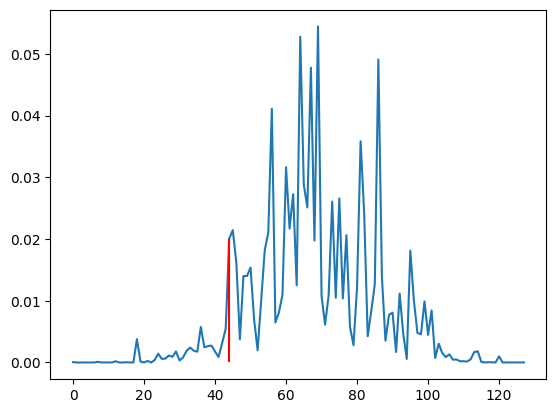

In [181]:
inp = [x[3:] for x in inputs]
inpn = [[ord(x) for x in i] for i in inp]

which = 4
from scipy.special import softmax
dist = softmax(preds[which][0][-1])
print(np.sum(dist))
plt.figure()
plt.plot(dist)
plt.vlines(ground_truths[which], ymin=0, ymax=dist[ground_truths[which]], color = 'r')
plt.show()
plt.close()